In [167]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer


Import the LIAR dataset

In [168]:
liar_train = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None)
liar_valid = pd.read_csv('liar_dataset/valid.tsv', sep='\t', header=None)
liar_test = pd.read_csv('liar_dataset/test.tsv', sep='\t', header=None)

Check columns name and rename them because they are not present in the dataset

In [169]:
print(liar_train.head())

liar_train.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue']
liar_valid.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue']
liar_test.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue']

           0            1                                                  2   \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                                   3               4                     5   \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

         6           7     8     9    

Start the preprocessing of the dataset. Remove uneccessary columns:

In [170]:
liar_train_new = liar_train.drop(['id', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue'], axis=1)
liar_valid_new = liar_valid.drop(['id', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue'], axis=1)
liar_test_new = liar_test.drop(['id', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'venue'], axis=1)

Remove entries half-true because they don't belong into the true or false category.

In [171]:
labels_to_remove = ['half-true']

liar_train_new = liar_train_new[~liar_train_new['label'].isin(labels_to_remove)]
liar_valid_new = liar_valid_new[~liar_valid_new['label'].isin(labels_to_remove)]
liar_test_new = liar_test_new[~liar_test_new['label'].isin(labels_to_remove)]

Transform pants-fire into false because it is a false statement.

In [172]:
liar_train_new['label'] = liar_train_new['label'].replace('pants-fire', 'false')
liar_valid_new['label'] = liar_valid_new['label'].replace('pants-fire', 'false')
liar_test_new['label'] = liar_test_new['label'].replace('pants-fire', 'false')
# 
liar_train_new['label'] = liar_train_new['label'].replace('barely-true', 'false')
liar_valid_new['label'] = liar_valid_new['label'].replace('barely-true', 'false')
liar_test_new['label'] = liar_test_new['label'].replace('barely-true', 'false')
# 
liar_train_new['label'] = liar_train_new['label'].replace('mostly-true', 'true')
liar_valid_new['label'] = liar_valid_new['label'].replace('mostly-true', 'true')
liar_test_new['label'] = liar_test_new['label'].replace('mostly-true', 'true')


Remove duplicates if present:

In [173]:
liar_train_new = liar_train_new.drop_duplicates(subset='statement')
liar_valid_new = liar_valid_new.drop_duplicates(subset='statement')
liar_test_new = liar_test_new.drop_duplicates(subset='statement')

The following function is used to clean the text. It converts the text to lowercase and removes URLs and extra spaces:
- The text is lowercased to ensure that the model does not treat the same word with different cases as different words. 
- URLs and extra spaces are removed because they do not provide any useful information for the model. 

In [174]:
def clean_text(text):
    text = text.lower() # lowercase text
    text = re.sub(r'http\S+|www.\S+', '', text)  # remove URLs
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

Clean the text in the dataset:

In [175]:
liar_train_new['statement'] = liar_train_new['statement'].apply(clean_text)
liar_valid_new['statement'] = liar_valid_new['statement'].apply(clean_text)
liar_test_new['statement'] = liar_test_new['statement'].apply(clean_text)

The following function is used to fix the number format. It replaces commas in numbers ('15,000' -> '15000'):

In [176]:
def fix_number_format(text):
    text = re.sub(r'(\d),(\d)', r'\1\2', text)
    return text

Apply the fix_number_format function to the dataset:

In [177]:
liar_train_new['statement'] = liar_train_new['statement'].apply(fix_number_format)
liar_valid_new['statement'] = liar_valid_new['statement'].apply(fix_number_format)
liar_test_new['statement'] = liar_test_new['statement'].apply(fix_number_format)

Remove null lines:

In [178]:
liar_train_new = liar_train_new[liar_train_new['statement'].str.strip().astype(bool)]
liar_valid_new = liar_valid_new[liar_valid_new['statement'].str.strip().astype(bool)]
liar_test_new = liar_test_new[liar_test_new['statement'].str.strip().astype(bool)]

Set size:

In [179]:
print('Training Set:', liar_train_new.shape)
print('Validation Set:', liar_valid_new.shape)
print('Testing Set:', liar_test_new.shape)

Training Set: (8116, 2)
Validation Set: (1036, 2)
Testing Set: (1002, 2)


Mean Word Count ( Average number of words in a statement);

In [180]:
liar_train_new['word_count'] = liar_train_new['statement'].apply(lambda x: len(x.split()))
liar_valid_new['word_count'] = liar_valid_new['statement'].apply(lambda x: len(x.split()))
liar_test_new['word_count'] = liar_test_new['statement'].apply(lambda x: len(x.split()))

print('Training Set:', liar_train_new['word_count'].mean())
print('Validation Set:', liar_valid_new['word_count'].mean())
print('Testing Set:', liar_test_new['word_count'].mean())


Training Set: 17.818506653523905
Validation Set: 17.55984555984556
Testing Set: 18.03393213572854


Median Word Count (Middle value of the word count)

In [181]:
print('Training Set:', liar_train_new['word_count'].median())
print('Validation Set:', liar_valid_new['word_count'].median())
print('Testing Set:', liar_test_new['word_count'].median())

Training Set: 16.0
Validation Set: 16.0
Testing Set: 16.0


Mode Word Count: (Most frequent word count)

In [182]:
print('Training Set:', liar_train_new['word_count'].mode()[0])
print('Validation Set:', liar_valid_new['word_count'].mode()[0])
print('Testing Set:', liar_test_new['word_count'].mode()[0])

Training Set: 13
Validation Set: 13
Testing Set: 16


Maximum Word Count: (Maximum number of words in a statement)

In [183]:
print('Training Set:', liar_train_new['word_count'].max())
print('Validation Set:', liar_valid_new['word_count'].max())
print('Testing Set:', liar_test_new['word_count'].max())

Training Set: 467
Validation Set: 53
Testing Set: 205


Minimum Word Count: (Minimum number of words in a statement)

In [184]:
print('Training Set:', liar_train_new['word_count'].min())
print('Validation Set:', liar_valid_new['word_count'].min())
print('Testing Set:', liar_test_new['word_count'].min())

Training Set: 2
Validation Set: 3
Testing Set: 2


Standard deviation:

In [185]:
print('Training Set:', liar_train_new['word_count'].std())
print('Validation Set:', liar_valid_new['word_count'].std())
print('Testing Set:', liar_test_new['word_count'].std())

Training Set: 10.023359410062836
Validation Set: 7.490882675703134
Testing Set: 9.59701743063028


IQR:

In [186]:
print('Training Set IQR:', liar_train_new['word_count'].quantile(0.75) - liar_train_new['word_count'].quantile(0.25))
print('Validation Set IQR:', liar_valid_new['word_count'].quantile(0.75) - liar_valid_new['word_count'].quantile(0.25))
print('Testing Set IQR:', liar_test_new['word_count'].quantile(0.75) - liar_test_new['word_count'].quantile(0.25))


Training Set IQR: 10.0
Validation Set IQR: 10.0
Testing Set IQR: 11.0


Check outliers:

In [187]:
Q1_train = liar_train_new['word_count'].quantile(0.25)
Q3_train = liar_train_new['word_count'].quantile(0.75)
IQR_train = Q3_train - Q1_train

Q1_valid = liar_valid_new['word_count'].quantile(0.25)
Q3_valid = liar_valid_new['word_count'].quantile(0.75)
IQR_valid = Q3_valid - Q1_valid

Q1_test = liar_test_new['word_count'].quantile(0.25)
Q3_test = liar_test_new['word_count'].quantile(0.75)
IQR_test = Q3_test - Q1_test

lower_bound_train = Q1_train - 1.5 * IQR_train
upper_bound_train = Q3_train + 1.5 * IQR_train

lower_bound_valid = Q1_valid - 1.5 * IQR_valid
upper_bound_valid = Q3_valid + 1.5 * IQR_valid

lower_bound_test = Q1_test - 1.5 * IQR_test
upper_bound_test = Q3_test + 1.5 * IQR_test

outliers_train = liar_train_new[(liar_train_new['word_count'] < lower_bound_train) | (liar_train_new['word_count'] > upper_bound_train)]
outliers_valid = liar_valid_new[(liar_valid_new['word_count'] < lower_bound_valid) | (liar_valid_new['word_count'] > upper_bound_valid)]
outliers_test = liar_test_new[(liar_test_new['word_count'] < lower_bound_test) | (liar_test_new['word_count'] > upper_bound_test)]

print(f'Outliers in Training Set: {len(outliers_train)}')
print(f'Outliers in Validation Set: {len(outliers_valid)}')
print(f'Outliers in Testing Set: {len(outliers_test)}')


Outliers in Training Set: 149
Outliers in Validation Set: 13
Outliers in Testing Set: 15


Remove the outliers:

In [188]:
liar_train_no_outliers = liar_train_new[(liar_train_new['word_count'] >= lower_bound_train) & (liar_train_new['word_count'] <= upper_bound_train)]
liar_valid_no_outliers = liar_valid_new[(liar_valid_new['word_count'] >= lower_bound_valid) & (liar_valid_new['word_count'] <= upper_bound_valid)]
liar_test_no_outliers = liar_test_new[(liar_test_new['word_count'] >= lower_bound_test) & (liar_test_new['word_count'] <= upper_bound_test)]

print(f'Remaining rows in Training Set: {len(liar_train_no_outliers)}')
print(f'Remaining rows in Validation Set: {len(liar_valid_no_outliers)}')
print(f'Remaining rows in Testing Set: {len(liar_test_no_outliers)}')


Remaining rows in Training Set: 7967
Remaining rows in Validation Set: 1023
Remaining rows in Testing Set: 987


Save the preprocessed dataset into a new dedicated folder:

In [189]:
liar_train_new.to_csv('preprocessed_liar/liar_train.csv', index=False)
liar_valid_new.to_csv('preprocessed_liar/liar_valid.csv', index=False)
liar_test_new.to_csv('preprocessed_liar/liar_test.csv', index=False)

Check the distribution of the word count in the training set:

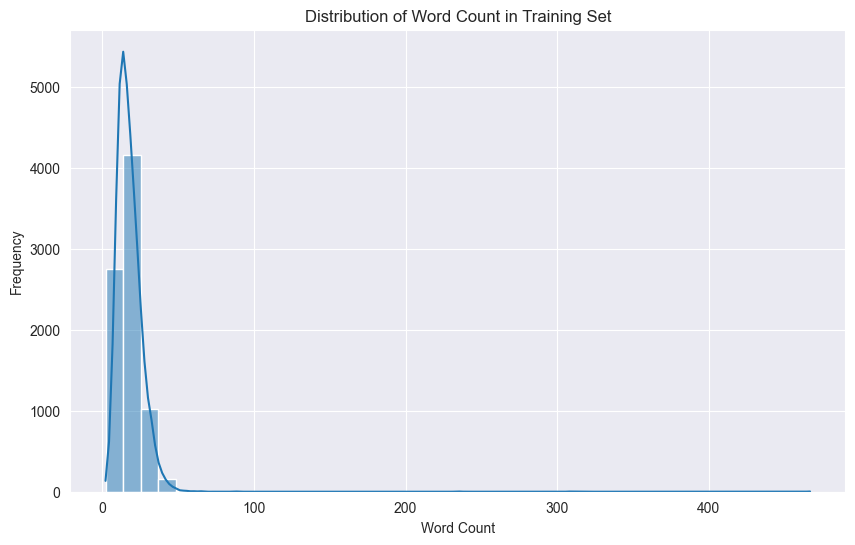

In [190]:
plt.figure(figsize=(10,6))
sns.histplot(liar_train_new['word_count'], bins=40, kde=True)
plt.title('Distribution of Word Count in Training Set')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Check the distribution of the word count in the testing set:

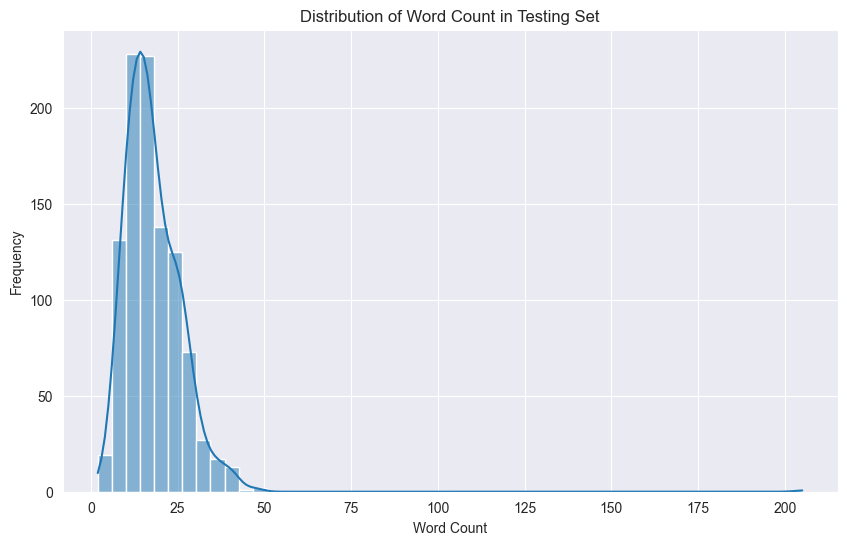

In [191]:
plt.figure(figsize=(10,6))
sns.histplot(liar_test_new['word_count'], bins=50, kde=True)
plt.title('Distribution of Word Count in Testing Set')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Check the distribution of the word count in the validation set:

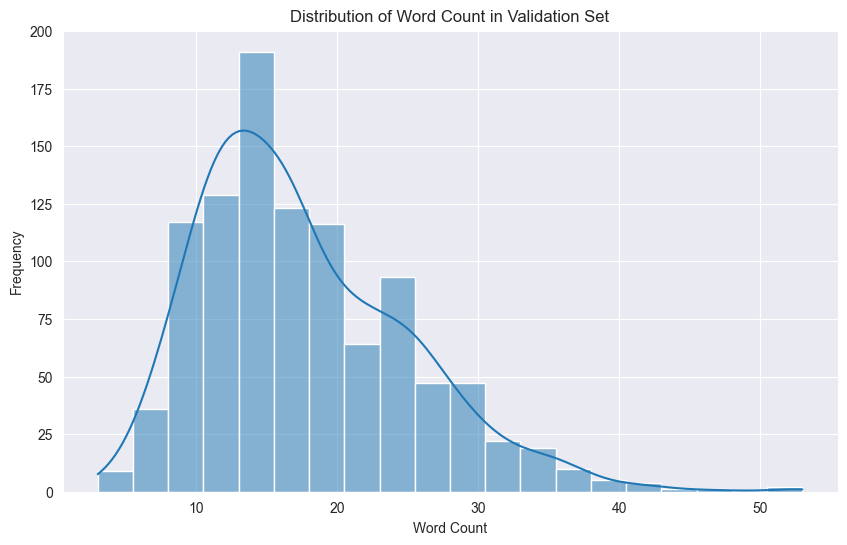

In [192]:
plt.figure(figsize=(10,6))
sns.histplot(liar_valid_new['word_count'], bins=20, kde=True)
plt.title('Distribution of Word Count in Validation Set')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Check the distribution of the text length in the training set:

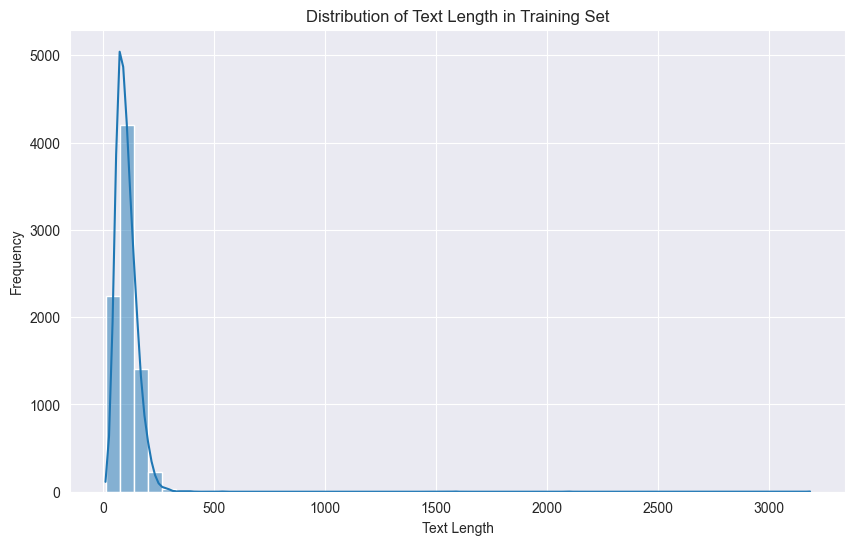

In [193]:
liar_train_new['text_length'] = liar_train_new['statement'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(liar_train_new['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length in Training Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Check the distribution of the text length in the testing set:

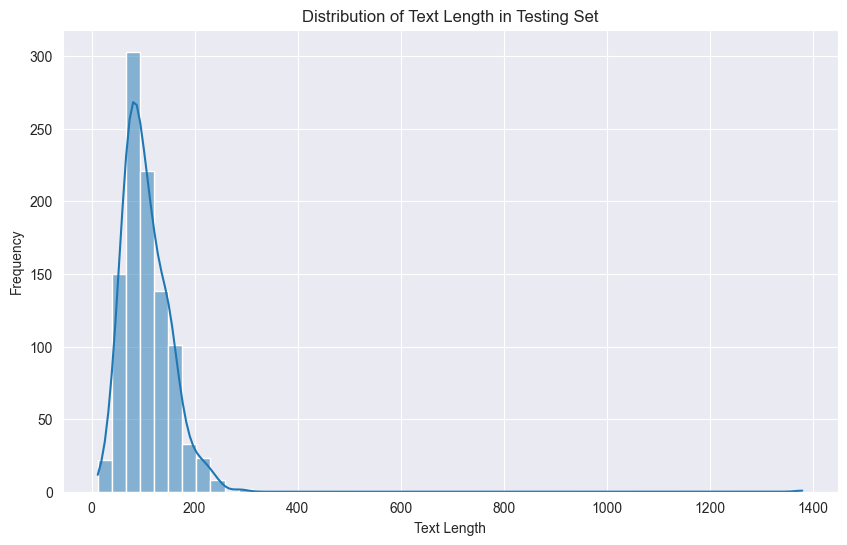

In [194]:
liar_test_new['text_length'] = liar_test_new['statement'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(liar_test_new['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length in Testing Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Check the distribution of the text length in the validation set:

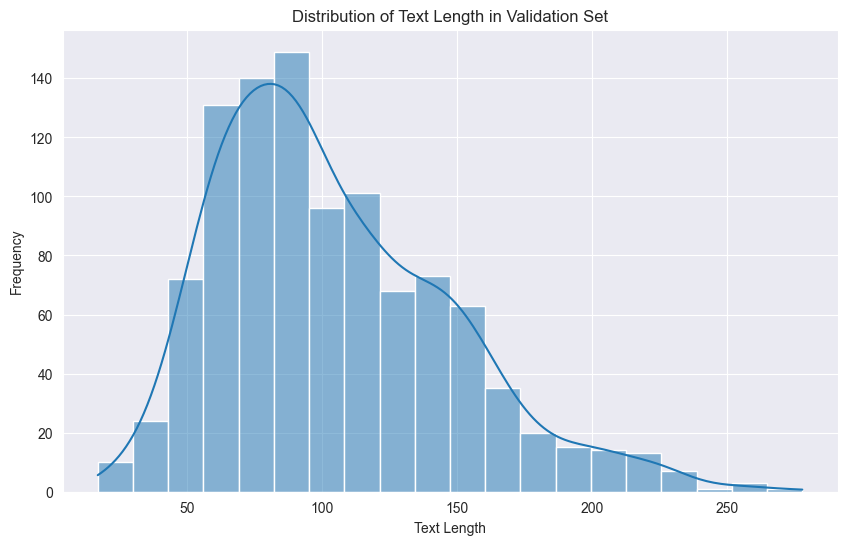

In [195]:
liar_valid_new['text_length'] = liar_valid_new['statement'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(liar_valid_new['text_length'], bins=20, kde=True)
plt.title('Distribution of Text Length in Validation Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Check the class distribution in the training set:

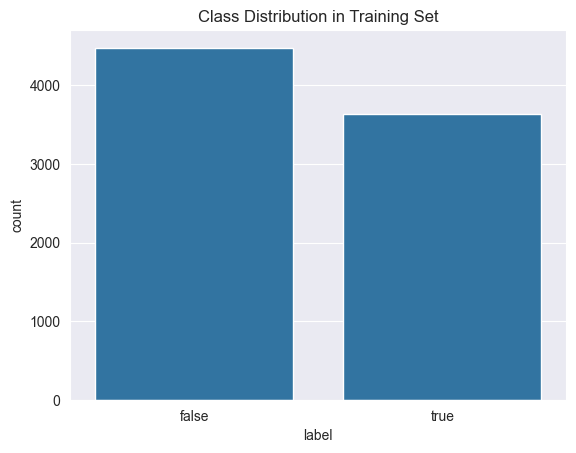

In [196]:
sns.countplot(x='label', data=liar_train_new)
plt.title('Class Distribution in Training Set')
plt.show()

Check the class distribution in the testing set:

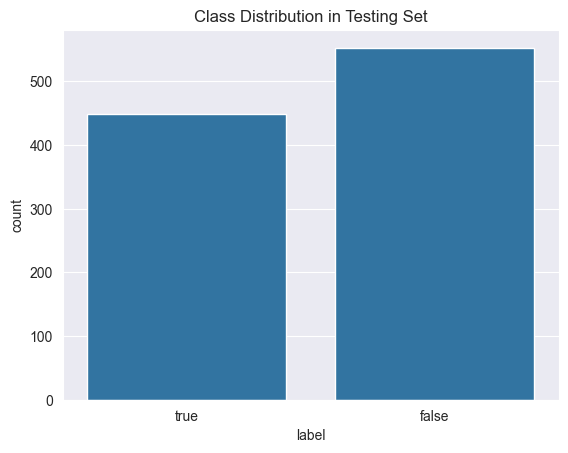

In [197]:
sns.countplot(x='label', data=liar_test_new)
plt.title('Class Distribution in Testing Set')
plt.show()

Check the class distribution in the validation set:

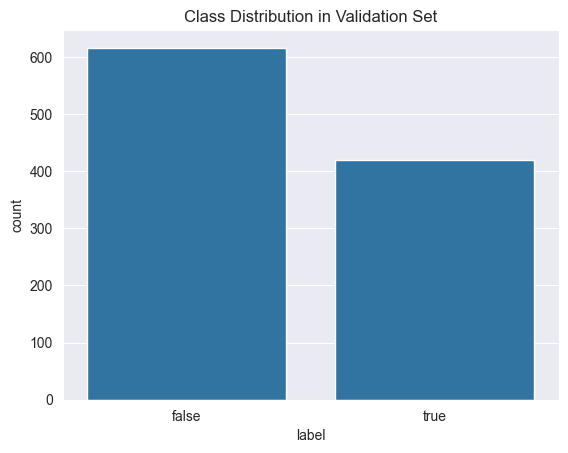

In [198]:
sns.countplot(x='label', data=liar_valid_new)
plt.title('Class Distribution in Validation Set')
plt.show()

Check the length of the text by class in the training set:

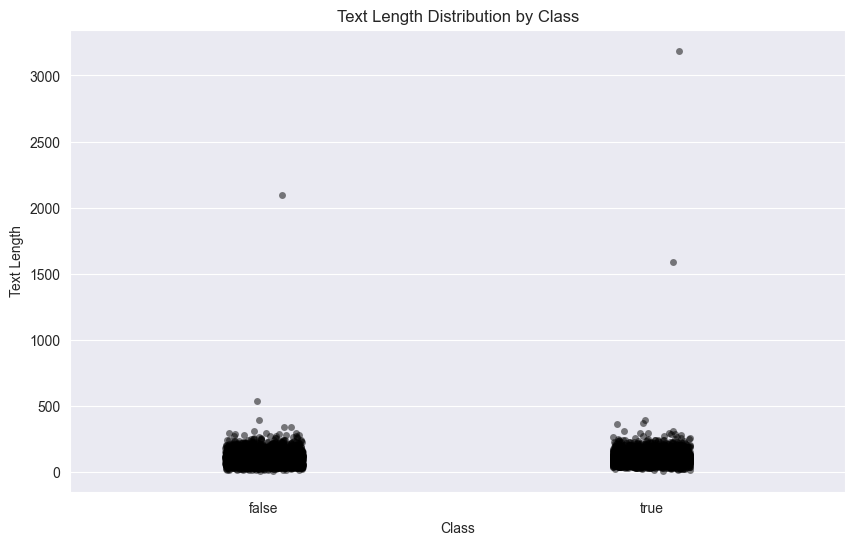

In [199]:
plt.figure(figsize=(10,6))
sns.stripplot(x='label', y='text_length', data=liar_train_new, color='black', alpha=0.5)
plt.title('Text Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

Check the length of the text by class in the testing set:

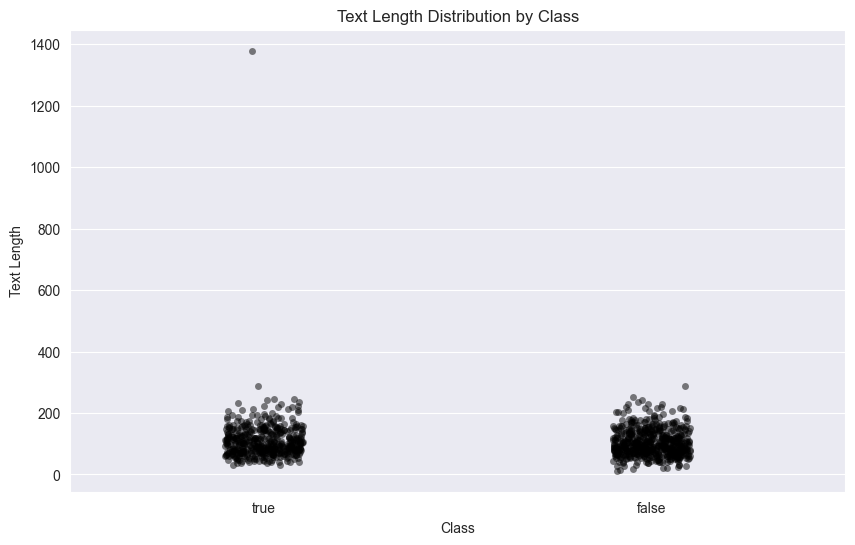

In [200]:
plt.figure(figsize=(10,6))
sns.stripplot(x='label', y='text_length', data=liar_test_new, color='black', alpha=0.5)
plt.title('Text Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

Check the length of the text by class in the validation set:

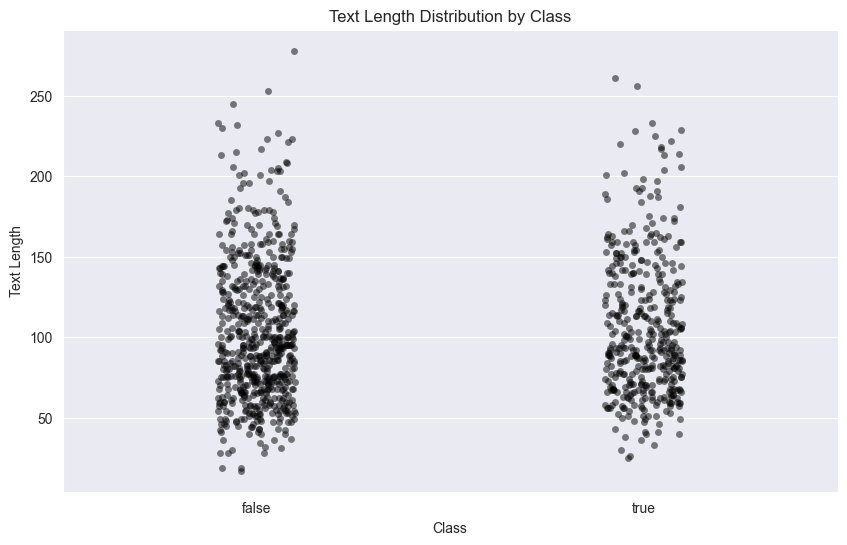

In [201]:
plt.figure(figsize=(10,6))
sns.stripplot(x='label', y='text_length', data=liar_valid_new, color='black', alpha=0.5)
plt.title('Text Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

Check the word frequency in the training set:

In [202]:
vectorizer = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))


X = vectorizer.fit_transform(liar_train_new['statement'])


ngrams = vectorizer.get_feature_names_out()
frequencies = X.sum(axis=0).A1
ngram_freq = dict(zip(ngrams, frequencies))

sorted_ngram_freq = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_ngram_freq)

[('says', 1876), ('percent', 903), ('state', 676), ('obama', 592), ('tax', 559), ('health', 493), ('president', 486), ('year', 480), ('years', 476), ('people', 469), ('care', 422), ('states', 421), ('million', 407), ('new', 372), ('jobs', 341), ('health care', 336), ('said', 306), ('texas', 299), ('billion', 294), ('federal', 292), ('voted', 292), ('barack', 288), ('government', 285), ('budget', 281), ('taxes', 279), ('country', 262), ('law', 252), ('barack obama', 245), ('pay', 243), ('united', 234), ('wisconsin', 226), ('united states', 223), ('plan', 210), ('time', 204), ('clinton', 203), ('money', 203), ('republican', 197), ('rate', 191), ('senate', 186), ('american', 184), ('americans', 176), ('cut', 174), ('public', 174), ('10', 172), ('florida', 171), ('insurance', 171), ('obamacare', 171), ('house', 170), ('just', 167), ('office', 167)]


Create a plot for the top 10 frequent words in the dataset:


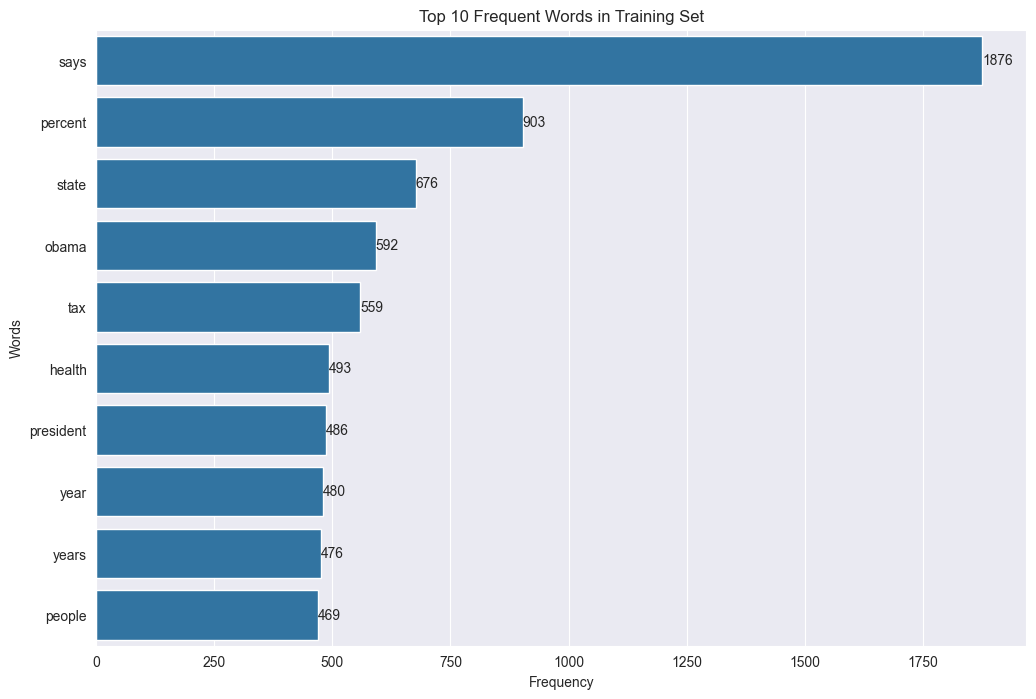

In [203]:
plt.figure(figsize=(12,8))
sns.barplot(x=[item[1] for item in sorted_ngram_freq[:10]], y=[item[0] for item in sorted_ngram_freq[:10]])
for index, value in enumerate([item[1] for item in sorted_ngram_freq[:10]]):
    plt.text(value, index, str(value), va='center')

plt.title('Top 10 Frequent Words in Training Set')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Check the word frequency in the testing set:

In [204]:
vectorizer = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))

X = vectorizer.fit_transform(liar_test_new['statement'])

ngrams = vectorizer.get_feature_names_out()
frequencies = X.sum(axis=0).A1
ngram_freq = dict(zip(ngrams, frequencies))

sorted_ngram_freq = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_ngram_freq)

[('says', 236), ('percent', 128), ('state', 85), ('obama', 80), ('tax', 69), ('president', 64), ('years', 64), ('health', 62), ('states', 60), ('year', 59), ('people', 54), ('care', 53), ('billion', 50), ('million', 48), ('federal', 46), ('barack', 45), ('health care', 44), ('new', 43), ('texas', 41), ('jobs', 39), ('barack obama', 36), ('money', 36), ('country', 35), ('government', 32), ('budget', 31), ('united', 31), ('united states', 31), ('voted', 31), ('americans', 29), ('law', 29), ('said', 28), ('public', 27), ('american', 26), ('spending', 26), ('pay', 25), ('plan', 25), ('time', 24), ('10', 23), ('clinton', 23), ('dollars', 23), ('going', 23), ('house', 23), ('republican', 23), ('children', 22), ('florida', 22), ('rate', 22), ('taxes', 22), ('congress', 21), ('debt', 21), ('president barack', 21)]


Create a plot for the top 10 frequent words in the dataset:

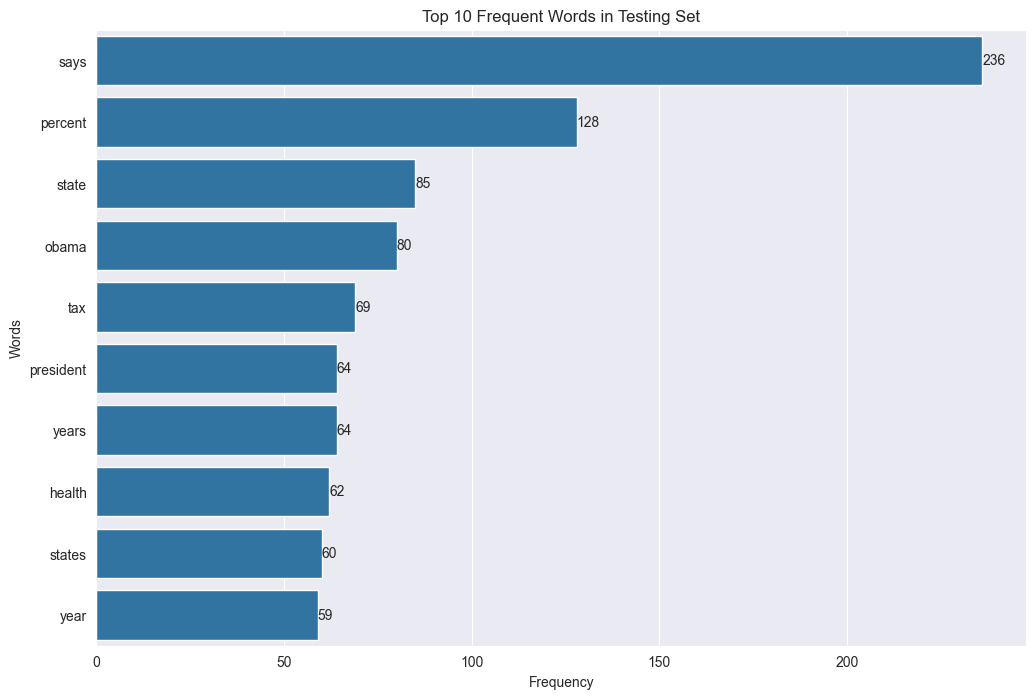

In [205]:
plt.figure(figsize=(12,8))
sns.barplot(x=[item[1] for item in sorted_ngram_freq[:10]], y=[item[0] for item in sorted_ngram_freq[:10]])
for index, value in enumerate([item[1] for item in sorted_ngram_freq[:10]]):
    plt.text(value, index, str(value), va='center')

plt.title('Top 10 Frequent Words in Testing Set')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Check the word frequency in the validation set:

In [206]:
vectorizer = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))

X = vectorizer.fit_transform(liar_valid_new['statement'])

ngrams = vectorizer.get_feature_names_out()
frequencies = X.sum(axis=0).A1
ngram_freq = dict(zip(ngrams, frequencies))

sorted_ngram_freq = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_ngram_freq)

[('says', 242), ('percent', 118), ('state', 85), ('health', 84), ('obama', 82), ('care', 74), ('health care', 64), ('president', 61), ('year', 59), ('jobs', 57), ('years', 57), ('million', 52), ('new', 49), ('tax', 49), ('people', 48), ('federal', 41), ('states', 40), ('plan', 38), ('voted', 37), ('said', 36), ('barack', 35), ('budget', 35), ('government', 34), ('law', 34), ('money', 34), ('time', 32), ('spending', 30), ('texas', 30), ('debt', 29), ('gov', 28), ('obamacare', 28), ('taxes', 28), ('wisconsin', 28), ('republican', 27), ('trillion', 27), ('barack obama', 26), ('american', 25), ('insurance', 25), ('public', 25), ('americans', 24), ('billion', 24), ('country', 24), ('got', 23), ('national', 23), ('school', 23), ('america', 22), ('georgia', 22), ('going', 22), ('job', 22), ('florida', 21)]


Create a plot for the top 10 frequent words in the dataset:

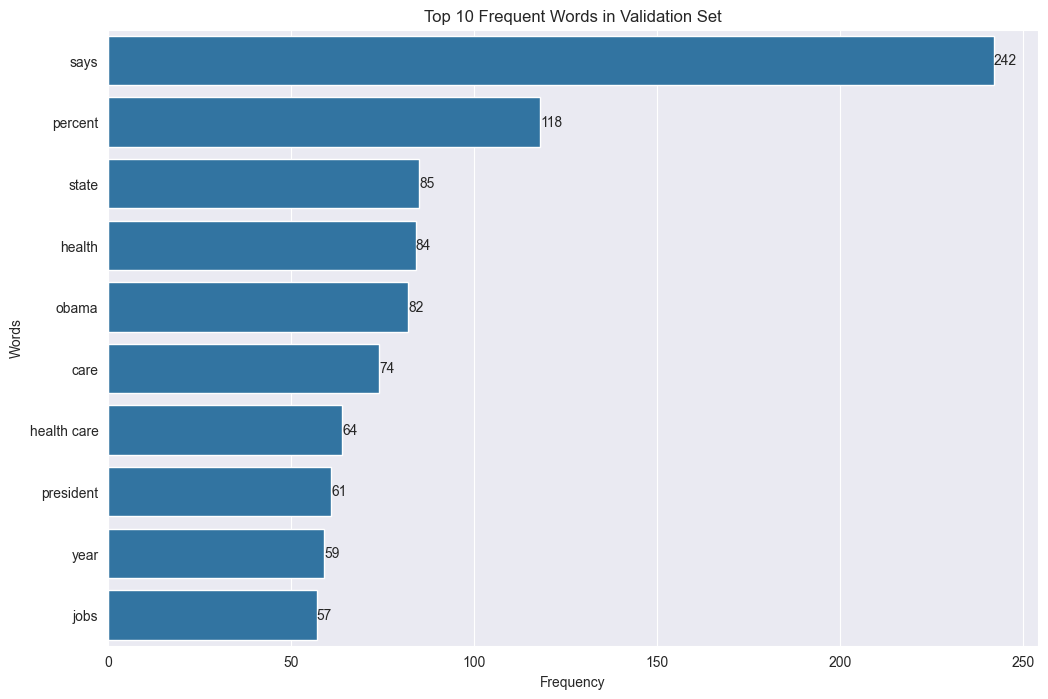

In [207]:
plt.figure(figsize=(12,8))
sns.barplot(x=[item[1] for item in sorted_ngram_freq[:10]], y=[item[0] for item in sorted_ngram_freq[:10]])
for index, value in enumerate([item[1] for item in sorted_ngram_freq[:10]]):
    plt.text(value, index, str(value), va='center')

plt.title('Top 10 Frequent Words in Validation Set')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()